# 虚拟电厂单用户调度（含储能）
- 光储荷经济性调度，针对单个用户、单个光伏、单个储能设备，短周期内的经济最优目标

# 变量
- 充电变量：$X = (x_t) \in [0, \alpha]$
- 放电变量：$Y = (y_t) \in [-\alpha, 0]$
- 储能设备能量状态：$S = (s_t) \in [0, 1]$

以上三个变量为 `continuous_var_list` 连续变量列表

# 参数
- 负荷：`load`
- 功率：`power`
- 电价：`price`
- 充电效率：`charge_efficiency`
- 放电效率：`discharge_efficiency`
- 储能单次充放电限制：`nominal_power`

# 目标函数
最小化经济性最优目标：
$$
\text{minimize } Cost = \sum_{t=1}^T (load(t) - power(t) + x(t) + y(t)) \times price(t) \div costbase
$$

其中 `costbase` 为不使用储能的情况下的花费：
$$
costbase = \sum_{t=1}^T (load(t) - power(t)) \times price(t)
$$

# 约束条件
- 储能能量状态：
  - 储能初始状态为 0：$s_0 = 0$
  - 储能状态更新：$s_t = s_{t-1} + c_1 \cdot x_t + \frac{y_t}{c_2}$


In [11]:
from docplex.mp.model import Model
import random

#设置一个随机种子
random.seed(1234)

# 创建模型，在这里我们对连续10个状态进行动态优化,电价有4个时段
time = 4
time1 = 5

# 生成随机的用户负荷和用户功率
user_loads = [round(random.uniform(0, 1), 2) for _ in range(time1)]
user_powers = [round(random.uniform(0, 1), 2) for _ in range(time1)]

elec_price = [0.54, 0.22, 0.32, 0.24]

#设置储能充放电效率和单次充放限制
charge_eff = 0.91
discharge_eff = 0.95

nominal_power = 0.8

model = Model(name='Electricity')
x = model.continuous_var_list(time, lb=0,ub=nominal_power,name='x')
y = model.continuous_var_list(time, lb = -nominal_power,ub = 0, name='y')
soc = model.continuous_var_list(time1,lb=0,ub=nominal_power,name='soc')

#无储能下的花费
cost_base = sum(((user_loads[i] - user_powers[i]) * elec_price[i]) for i in range(time))
#总花费
total_cost = model.sum(((user_loads[i] - user_powers[i] + x[i] + y[i]) * elec_price[i] / cost_base) for i in range(time))

model.minimize(total_cost)
model.add_constraint(soc[0] == 0)

for i in range(time):
    model.add_constraint(soc[i+1] == soc[i] + x[i] * charge_eff + y[i]/discharge_eff)
model.solve()

print('The optimized solution is:')
print("charging(+)/discharging(-) power for each time step:")
for i in range(time):
    print("time{}:solution:".format(i),x[i].solution_value+y[i].solution_value)

for i in range(time1):
    print('time{}:soc{}'.format(i,soc[i].solution_value))

print('Total cost:{}'.format(total_cost.solution_value))

The optimized solution is:
charging(+)/discharging(-) power for each time step:
time0:solution: 0
time1:solution: 0.8
time2:solution: -0.6916000000000001
time3:solution: 0
time0:soc0
time1:soc0
time2:soc0.7280000000000001
time3:soc0
time4:soc0
Total cost:0.7353271028037383


In [1]:
from docplex.mp.model import Model
import random

# 随机种子
random.seed(1234)

# 创建模型，在这里我们对连续5个状态进行动态优化,电价有5个时段
time = 5

# 生成随机的用户负荷和用户功率
user_loads = [round(random.uniform(0, 1), 2) for _ in range(time)]
user_powers = [round(random.uniform(0, 1), 2) for _ in range(time)]

elec_price = [0.54, 0.22, 0.32, 0.24, 0.45]  # 与时间保持一致

# 设置储能充放电效率和单次充放限制
charge_eff = 0.91
discharge_eff = 0.95
nominal_power = 0.8

# 创建模型
model = Model(name='Electricity')

# 创建变量
x = model.continuous_var_list(time, lb=0, ub=nominal_power, name='x')
y = model.continuous_var_list(time, lb=-nominal_power, ub=0, name='y')
soc = model.continuous_var_list(time, lb=0, ub=nominal_power, name='soc')

# 无储能下的花费
cost_base = sum(((user_loads[i] - user_powers[i]) * elec_price[i]) for i in range(time))

# 总花费
total_cost = model.sum(((user_loads[i] - user_powers[i] + x[i] + y[i]) * elec_price[i] / cost_base) for i in range(time))

# 设置目标函数
model.minimize(total_cost)

# 添加约束条件
model.add_constraint(soc[0] == 0)

for i in range(time - 1):
    model.add_constraint(soc[i + 1] == soc[i] + x[i] * charge_eff + y[i] / discharge_eff)

# 求解模型
solution = model.solve()

# 检查是否找到最优解
if solution:
    print('The optimized solution is:')
    print("charging(+)/discharging(-) power for each time step:")
    for i in range(time):
        print(f"time {i}: solution: {x[i].solution_value + y[i].solution_value}")

    for i in range(time):
        print(f"time {i}: soc {soc[i].solution_value}")

    print(f'Total cost: {total_cost.solution_value}')
else:
    print("No solution found.")


The optimized solution is:
charging(+)/discharging(-) power for each time step:
time 0: solution: 0
time 1: solution: 0.8
time 2: solution: -0.6916000000000001
time 3: solution: 0
time 4: solution: -0.8
time 0: soc 0
time 1: soc 0
time 2: soc 0.7280000000000001
time 3: soc 0
time 4: soc 0
Total cost: 0.16636774989716163


The optimized solution is:
charging(+)/discharging(-) power for each time step:
Hour 0: solution: 0.10839999999999994
Hour 1: solution: 0.2851999999999997
Hour 2: solution: 0.8
Hour 3: solution: 0.10840000000000005
Hour 4: solution: 0.8
Hour 5: solution: 0.8
Hour 6: solution: 0.8
Hour 7: solution: -0.7537304800462696
Hour 8: solution: 0.0
Hour 9: solution: -0.7537304800462696
Hour 10: solution: 0.0
Hour 11: solution: -0.6746096009253907
Hour 12: solution: 0.10839999999999994
Hour 13: solution: 0.17679999999999985
Hour 14: solution: 0.0
Hour 15: solution: 0.0
Hour 16: solution: 0.17679999999999985
Hour 17: solution: 0.10839999999999994
Hour 18: solution: -0.7537304800462696
Hour 19: solution: 0.0
Hour 20: solution: -0.6283400809716602
Hour 21: solution: 0.8
Hour 22: solution: 0.0
Hour 23: solution: 0.10839999999999994


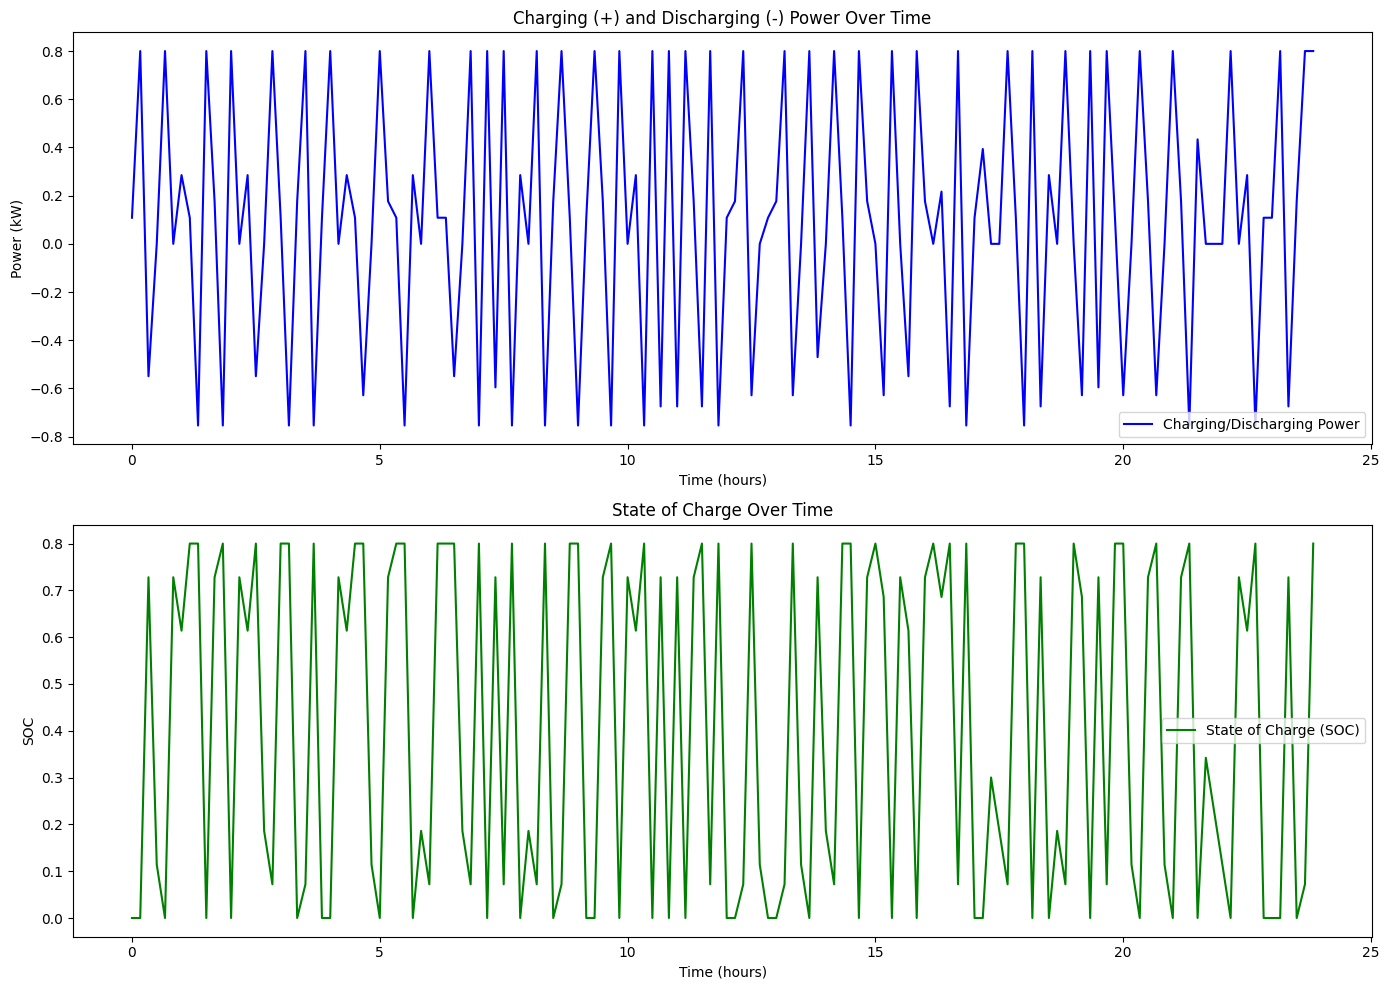

Total cost: -2.5496332782861226


In [2]:
#24小时每10分钟进行一次决策，将电价进行随机化（非指定），并设置电价波动范围为±0.2，并设置充放电效率和单次充放限制，并设置目标函数为最小化总花费，并添加约束条件，使得电量平衡，并求解模型，并可视化结果。
from docplex.mp.model import Model
import random
import matplotlib.pyplot as plt

# 设置一个随机种子
random.seed(1234)

# 创建模型，在这里我们对一天24小时进行动态优化，每10分钟采样一次
sampling_interval = 10  # 每10分钟采样一次
minutes_per_day = 24 * 60  # 一天共有 1440 分钟
time = minutes_per_day // sampling_interval  # 采样点数量

# 生成随机的用户负荷和用户功率
user_loads = [round(random.uniform(0, 1), 2) for _ in range(time)]
user_powers = [round(random.uniform(0, 1), 2) for _ in range(time)]

# 生成随机电价，基于 0.5 生成 ±0.2 的波动
elec_price = [round(0.5 + random.uniform(-0.2, 0.2), 2) for _ in range(time)]

# 设置储能充放电效率和单次充放限制
charge_eff = 0.91
discharge_eff = 0.95
nominal_power = 0.8

# 创建模型
model = Model(name='Electricity')

# 创建变量
x = model.continuous_var_list(time, lb=0, ub=nominal_power, name='x')
y = model.continuous_var_list(time, lb=-nominal_power, ub=0, name='y')
soc = model.continuous_var_list(time, lb=0, ub=nominal_power, name='soc')

# 无储能下的花费
cost_base = sum(((user_loads[i] - user_powers[i]) * elec_price[i]) for i in range(time))

# 总花费
total_cost = model.sum(((user_loads[i] - user_powers[i] + x[i] + y[i]) * elec_price[i] / cost_base) for i in range(time))

# 设置目标函数
model.minimize(total_cost)

# 添加约束条件
model.add_constraint(soc[0] == 0)
for i in range(time - 1):
    model.add_constraint(soc[i + 1] == soc[i] + x[i] * charge_eff + y[i] / discharge_eff)

# 求解模型
solution = model.solve()

# 检查是否找到最优解
if solution:
    print('The optimized solution is:')
    print("charging(+)/discharging(-) power for each time step:")
    charging_discharge_values = []
    soc_values = []
    
    for i in range(time):
        charge_discharge = x[i].solution_value + y[i].solution_value
        charging_discharge_values.append(charge_discharge)
        soc_values.append(soc[i].solution_value)
        if i % (60 // sampling_interval) == 0:  # 每小时输出一次状态
            print(f"Hour {i // (60 // sampling_interval)}: solution: {charge_discharge}")
    
    # 可视化结果
    hours = [i * sampling_interval / 60 for i in range(time)]
    
    plt.figure(figsize=(14, 10))
    
    # 充放电功率可视化
    plt.subplot(2, 1, 1)
    plt.plot(hours, charging_discharge_values, label='Charging/Discharging Power', color='b')
    plt.xlabel('Time (hours)')
    plt.ylabel('Power (kW)')
    plt.title('Charging (+) and Discharging (-) Power Over Time')
    plt.legend()

    # SOC 状态可视化
    plt.subplot(2, 1, 2)
    plt.plot(hours, soc_values, label='State of Charge (SOC)', color='g')
    plt.xlabel('Time (hours)')
    plt.ylabel('SOC')
    plt.title('State of Charge Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f'Total cost: {total_cost.solution_value}')
else:
    print("No solution found.")


The optimized solution is:
charging(+)/discharging(-) power for each time step:
Hour 0: solution: 0
Hour 1: solution: 0
Hour 2: solution: -0.6080000000000001
Hour 3: solution: -0.6080000000000001
Hour 4: solution: -0.6080000000000001
Hour 5: solution: 0
Hour 6: solution: -0.6080000000000001
Hour 7: solution: -0.6080000000000001
Hour 8: solution: 0
Hour 9: solution: 0
Hour 10: solution: 0
Hour 11: solution: -0.6080000000000001
Hour 12: solution: 0
Hour 13: solution: 0
Hour 14: solution: -0.6080000000000001
Hour 15: solution: 0
Hour 16: solution: -0.6080000000000001
Hour 17: solution: 0
Hour 18: solution: 0
Hour 19: solution: -0.6080000000000001
Hour 20: solution: 0
Hour 21: solution: 0
Hour 22: solution: 0
Hour 23: solution: 0
Hour 24: solution: -0.6080000000000001
Hour 25: solution: 0
Hour 26: solution: 0
Hour 27: solution: 0
Hour 28: solution: 0
Hour 29: solution: 0
Hour 30: solution: -0.6080000000000001
Hour 31: solution: 0
Hour 32: solution: 0
Hour 33: solution: 0
Hour 34: solution:

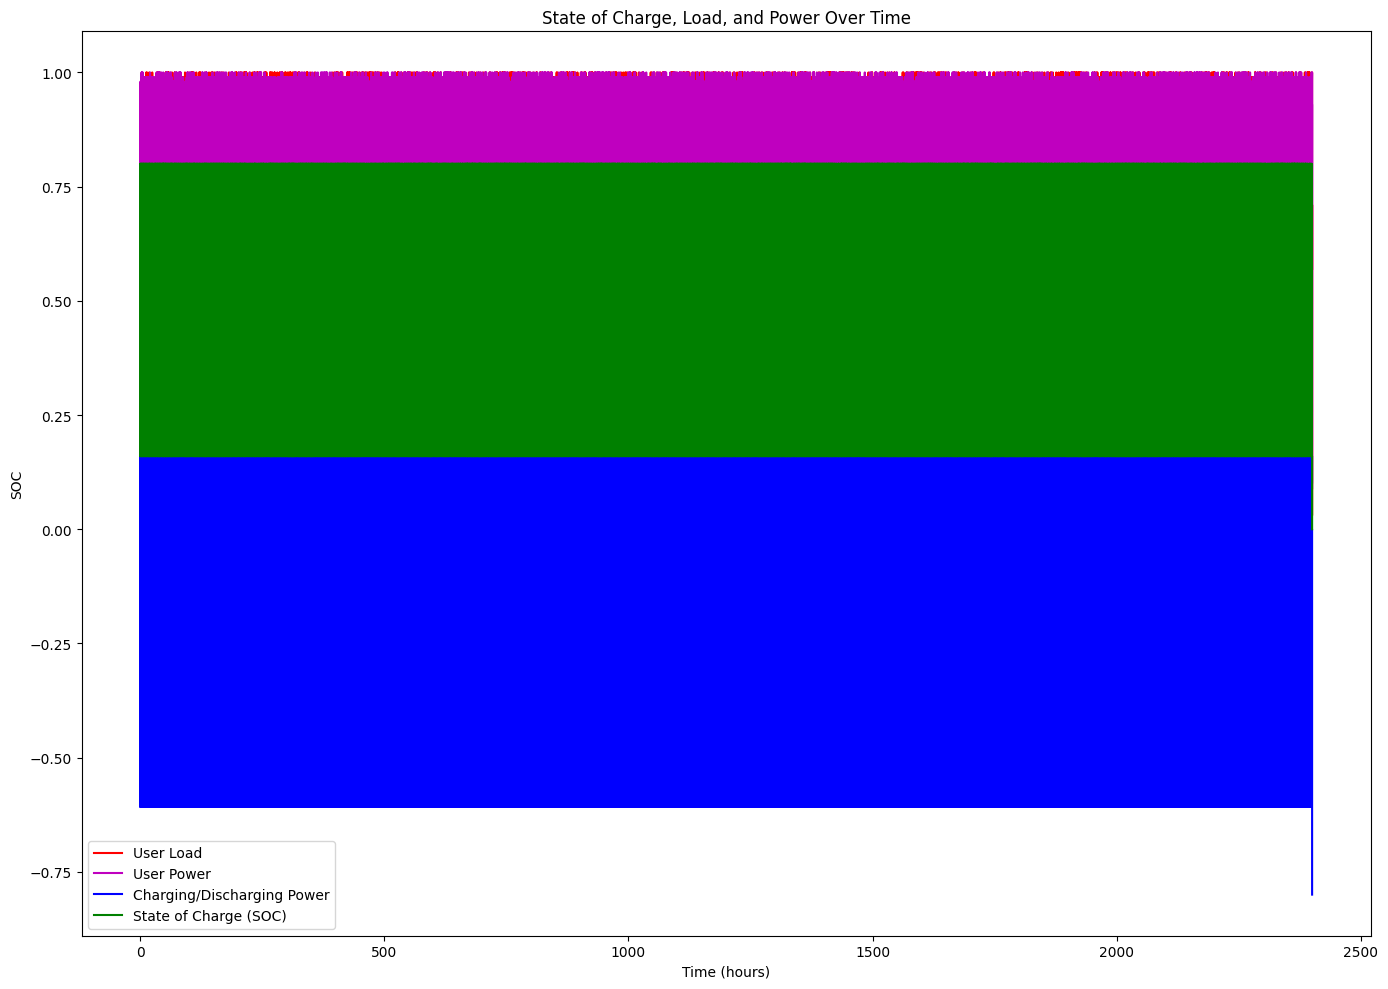

Total cost: -196.08286351648874


In [11]:
from docplex.mp.model import Model
import random
import matplotlib.pyplot as plt

# 设置一个随机种子
random.seed(1234)

# 创建模型，在这里我们对一天24小时进行动态优化，每30分钟采样一次
sampling_interval = 1  # 每30分钟采样一次
minutes_per_day = 24 * 6000  # 一天共有 1440 分钟
time = minutes_per_day // sampling_interval  # 采样点数量

# 生成随机的用户负荷和用户功率
user_loads = [round(random.uniform(0, 1), 2) for _ in range(time)]
user_powers = [round(random.uniform(0, 1), 2) for _ in range(time)]

# 生成随机电价，每2小时变动一次，基于 0.5 生成 ±0.2 的波动
elec_price = []
for i in range(0, time, 12):  # 每2小时（12个采样点）生成一个电价
    price = round(0.5 + random.uniform(-0.2, 0.2), 2)
    elec_price.extend([price] * 12)

# 设置储能充放电效率和单次充放限制
charge_eff = 0.91
discharge_eff = 0.95
nominal_power = 0.8

# 创建模型
model = Model(name='Electricity')
model.parameters.threads.set(0)
# 创建变量
x = model.continuous_var_list(time, lb=0, ub=nominal_power, name='x')
y = model.continuous_var_list(time, lb=-nominal_power, ub=0, name='y')
soc = model.continuous_var_list(time, lb=0, ub=nominal_power, name='soc')

# 无储能下的花费
cost_base = sum(((user_loads[i] - user_powers[i]) * elec_price[i]) for i in range(time))

# 总花费
total_cost = model.sum(((user_loads[i] - user_powers[i] + x[i] + y[i]) * elec_price[i]) for i in range(time))

# 设置目标函数
model.minimize(total_cost)

# 添加约束条件
min_soc = 0.2 * nominal_power  # 最小 SOC 限制
model.add_constraint(soc[0] == 0.5 * nominal_power)  # 初始 SOC 设置为 0.5

for i in range(time - 1):
    # SOC 状态更新约束
    model.add_constraint(soc[i + 1] == soc[i] + x[i] * charge_eff + y[i] / discharge_eff)
    # 最小 SOC 约束
    model.add_constraint(soc[i] >= min_soc)

# 放电后的冷却时间约束（通过引入额外的二进制变量来表示冷却状态）
for i in range(time - 2):
    # 创建二进制变量来表示冷却状态
    cooling_20 = model.binary_var(name=f'cooling_20_{i}')
    cooling_10 = model.binary_var(name=f'cooling_10_{i}')
    
    # 冷却 20 分钟约束，当放电量超过 50% 时触发冷却
    model.add_indicator(cooling_20, y[i] <= -0.5 * nominal_power, 1)
    model.add_constraint(x[i + 1] <= nominal_power * (1 - cooling_20))  # 冷却期间不可充电
    
    # 冷却 10 分钟约束，当放电量在 30% - 50% 之间时触发冷却
    model.add_indicator(cooling_10, y[i] <= -0.3 * nominal_power, 1)
    model.add_constraint(x[i + 1] <= nominal_power * (1 - cooling_10))  # 冷却期间不可充电

solution = model.solve()

# 检查是否找到最优解
if solution:
    print('The optimized solution is:')
    print("charging(+)/discharging(-) power for each time step:")
    charging_discharge_values = []
    soc_values = []
    
    for i in range(time):
        charge_discharge = x[i].solution_value + y[i].solution_value
        charging_discharge_values.append(charge_discharge)
        soc_values.append(soc[i].solution_value)
        if i % (60 // sampling_interval) == 0:  # 每小时输出一次状态
            print(f"Hour {i // (60 // sampling_interval)}: solution: {charge_discharge}")
    
    # 可视化结果
    hours = [i * sampling_interval / 60 for i in range(time)]
    
    plt.figure(figsize=(14, 10))
    
    # 负荷、用户功率和充放电功率可视化
    plt.plot(hours, user_loads, label='User Load', color='r')
    plt.plot(hours, user_powers, label='User Power', color='m')
    plt.plot(hours, charging_discharge_values, label='Charging/Discharging Power', color='b')
    plt.xlabel('Time (hours)')
    plt.ylabel('Power (kW)')
    plt.title('Load, Power, and Charging/Discharging Over Time')
    plt.legend()
    
    # SOC 状态可视化
    plt.plot(hours, soc_values, label='State of Charge (SOC)', color='g')
    plt.ylabel('SOC')
    plt.title('State of Charge, Load, and Power Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f'Total cost: {total_cost.solution_value}')
else:
    print("No solution found.")


In [1]:
pip install gurobipy

   ---------------------------------------- 0.0/10.3 MB ? eta -:--:--
   - -------------------------------------- 0.3/10.3 MB ? eta -:--:--
   -- ------------------------------------- 0.5/10.3 MB 2.1 MB/s eta 0:00:05
   ---- ----------------------------------- 1.0/10.3 MB 2.1 MB/s eta 0:00:05
   ----- ---------------------------------- 1.3/10.3 MB 1.6 MB/s eta 0:00:06
   ----- ---------------------------------- 1.3/10.3 MB 1.6 MB/s eta 0:00:06
   ------- -------------------------------- 1.8/10.3 MB 1.5 MB/s eta 0:00:06
   --------- ------------------------------ 2.4/10.3 MB 1.7 MB/s eta 0:00:05
   ------------- -------------------------- 3.4/10.3 MB 2.1 MB/s eta 0:00:04
   ---------------- ----------------------- 4.2/10.3 MB 2.3 MB/s eta 0:00:03
   ------------------ --------------------- 4.7/10.3 MB 2.4 MB/s eta 0:00:03
   --------------------- ------------------ 5.5/10.3 MB 2.4 MB/s eta 0:00:02
   ------------------------ --------------- 6.3/10.3 MB 2.6 MB/s eta 0:00:02
   ----------

In [2]:
import cplex
import docplex
import os
print(os.path.dirname(cplex.__file__))

c:\Users\JH_personal\AppData\Local\Programs\Python\Python310\lib\site-packages\cplex-22.1.1.0-py3.10.egg\cplex


In [2]:
import cplex

# 创建 CPLEX 求解器对象
problem = cplex.Cplex()

# 设置为最大化问题
problem.objective.set_sense(problem.objective.sense.maximize)

# 设置变量数量
num_vars = 1500  # 设置变量数量超过 1000
var_names = [f"x{i}" for i in range(num_vars)]
objective_coeffs = [1.0] * num_vars  # 目标函数系数全为 1
lower_bounds = [0.0] * num_vars  # 下界为 0
upper_bounds = [cplex.infinity] * num_vars  # 无上界

# 添加变量到问题中
problem.variables.add(obj=objective_coeffs, lb=lower_bounds, ub=upper_bounds, names=var_names)

# 设置约束数量
num_constraints = 1000  # 设置约束数量超过 1000
constraints = []
rhs = []
constraint_senses = []

# 添加约束
for i in range(num_constraints):
    # 生成随机系数
    coeffs = [1.0] * num_vars  # 所有变量的系数都为 1
    constraints.append([var_names, coeffs])
    rhs.append(num_vars)  # 右侧常数为变量数量
    constraint_senses.append("L")  # 所有约束均为 <=

# 添加约束到问题中
problem.linear_constraints.add(lin_expr=constraints, senses=constraint_senses, rhs=rhs)

# 求解
problem.solve()

# 输出结果
print("Solution status: ", problem.solution.get_status())
print("Optimal value: ", problem.solution.get_objective_value())
solution_values = problem.solution.get_values()

# 打印前10个变量的最优解
for i in range(min(10, len(var_names))):
    print(f"Variable {var_names[i]}: {solution_values[i]}")


Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 1000 rows and 1500 columns.
All rows and columns eliminated.
Presolve time = 0.05 sec. (96.25 ticks)
Solution status:  1
Optimal value:  1500.0
Variable x0: 0.0
Variable x1: 0.0
Variable x2: 1500.0
Variable x3: 0.0
Variable x4: 0.0
Variable x5: 0.0
Variable x6: 0.0
Variable x7: 0.0
Variable x8: 0.0
Variable x9: 0.0


In [3]:
import cplex
import random
import matplotlib.pyplot as plt

# 设置一个随机种子
random.seed(1234)

# 创建模型，在这里我们对一天24小时进行动态优化，每30分钟采样一次
sampling_interval = 30  # 每30分钟采样一次
minutes_per_day = 24 * 60  # 一天共有 1440 分钟
time = minutes_per_day // sampling_interval  # 采样点数量
print(time)
# 生成随机的用户负荷和用户功率
user_loads = [round(random.uniform(0, 1), 2) for _ in range(time)]
user_powers = [round(random.uniform(0, 1), 2) for _ in range(time)]
print(user_loads)
# 生成随机电价，每2小时变动一次，基于 0.5 生成 ±0.2 的波动
elec_price = []
for i in range(0, time, 12):  # 每2小时（12个采样点）生成一个电价
    price = round(0.5 + random.uniform(-0.2, 0.2), 2)
    elec_price.extend([price] * 12)
print('电价',elec_price)
# 设置储能充放电效率和单次充放限制
charge_eff = 0.91
discharge_eff = 0.95
nominal_power = 0.8

# 创建 CPLEX 模型
model = cplex.Cplex()
model.set_problem_type(cplex.Cplex.problem_type.LP)

# 创建变量
x_names = [f"x{i}" for i in range(time)]
y_names = [f"y{i}" for i in range(time)]
soc_names = [f"soc{i}" for i in range(time)]
print(x_names)
model.variables.add(names=x_names, lb=[0] * time, ub=[nominal_power] * time)
model.variables.add(names=y_names, lb=[-nominal_power] * time, ub=[0] * time)
model.variables.add(names=soc_names, lb=[0] * time, ub=[nominal_power] * time)

# 无储能下的花费
cost_base = sum(((user_loads[i] - user_powers[i]) * elec_price[i]) for i in range(time))
print(cost_base)
# 设置目标函数
model.objective.set_sense(model.objective.sense.minimize)

# 计算总花费
total_cost = []
for i in range(time):
    total_cost.append((user_loads[i] - user_powers[i] + 0) * elec_price[i])  # 充电和放电部分在求解后计算
print(total_cost)
# 添加约束条件
min_soc = 0.2 * nominal_power  # 最小 SOC 限制
model.linear_constraints.add(lin_expr=[[soc_names, [1] * time]], senses=["G"], rhs=[0.5 * nominal_power])  # 初始 SOC 设置为 0.5

for i in range(time - 1):
    # SOC 状态更新约束
    model.linear_constraints.add(lin_expr=[[soc_names[i:i + 2], [1, -1, charge_eff, -1 / discharge_eff]]], senses=["E"], rhs=[0])  # 更新 SOC
    # 最小 SOC 约束
    model.linear_constraints.add(lin_expr=[[soc_names[i:i + 1], [1]]], senses=["G"], rhs=[min_soc])  # 最小 SOC 限制



# 求解模型
solution = model.solve()
print('solution',model.solution.get_status(), model.solution.status.optimal)
print(solution)

# 检查是否找到最优解
if solution and model.solution.get_status() == model.solution.status.optimal:
    print('The optimized solution is:')
    print("charging(+)/discharging(-) power for each time step:")
    
    charging_discharge_values = []
    soc_values = []
    
    for i in range(time):
        charge_discharge = x[i].solution_value + y[i].solution_value
        charging_discharge_values.append(charge_discharge)
        soc_values.append(soc[i].solution_value)
        if i % (60 // sampling_interval) == 0:  # 每小时输出一次状态
            print(f"Hour {i // (60 // sampling_interval)}: solution: {charge_discharge}")
    
    # 可视化结果
    hours = [i * sampling_interval / 60 for i in range(time)]
    
    plt.figure(figsize=(14, 10))
    
    # 负荷、用户功率和充放电功率可视化
    plt.plot(hours, user_loads, label='User Load', color='r')
    plt.plot(hours, user_powers, label='User Power', color='m')
    plt.plot(hours, charging_discharge_values, label='Charging/Discharging Power', color='b')
    plt.xlabel('Time (hours)')
    plt.ylabel('Power (kW)')
    plt.title('Load, Power, and Charging/Discharging Over Time')
    plt.legend()
    
    # SOC 状态可视化
    plt.plot(hours, soc_values, label='State of Charge (SOC)', color='g')
    plt.ylabel('SOC')
    plt.title('State of Charge, Load, and Power Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f'Total cost: {total_cost.solution_value}')
else:
    print("No solution found.")


ModuleNotFoundError: No module named 'cplex'